In [1]:
import numpy as np
import pandas as pd
from pprint import pprint

from pathlib import Path


from awpy import DemoParser
from awpy.analytics.stats import player_stats
from awpy.analytics.wpa import (state_win_probability, round_win_probability)
from awpy.data import (NAV,NAV_CSV, MAP_DATA)
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from awpy.visualization.plot import (plot_map, plot_round, plot_positions, plot_nades)

from IPython.display import Image


import plotly.tools as tls
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.express as px
import plotly.figure_factory as ff

import os
from imageio.v3 import imread

import awpy.data as awpydata

In [2]:
data_path = Path("/Users/iqbal/Documents/mirandalabs/datasets/BLAST-Premier-Fall-Series-2020-og-vs-natus-vincere-bo3")
dataset = Path("/Users/iqbal/Documents/mirandalabs/datasets")

In [ ]:
plot_positions()

In [3]:
demo_parser = DemoParser(
    demofile = f"{data_path}/og-vs-natus-vincere-m1-dust2.dem",
    outpath= Path.cwd(),
    demo_id = "OG-NaVi-BLAST2020", 
    parse_rate=128, 
    trade_time=5, 
    buy_style="hltv"
)


# Parse the demofile, output results to dictionary
data = demo_parser.parse()


In [4]:
total_rounds = len(data["gameRounds"])

assert total_rounds<=30, "Total Rounds cannot be more than 30"

In [5]:
[data["gameRounds"][i]["roundEndReason"] for i in range(len(data["gameRounds"]))]

['CTWin',
 'TerroristsWin',
 'TerroristsWin',
 'TerroristsWin',
 'CTWin',
 'TargetSaved',
 'TargetBombed',
 'TargetSaved',
 'CTWin',
 'CTWin',
 'CTWin',
 'CTWin',
 'TargetSaved',
 'TargetBombed',
 'TerroristsWin',
 'BombDefused',
 'TerroristsWin',
 'TerroristsWin',
 'TerroristsWin',
 'TargetBombed',
 'TargetBombed',
 'BombDefused',
 'CTWin',
 'TargetBombed',
 'TerroristsWin']

In [6]:
shortest_round, *_ , longest_round = np.argsort([len(round["frames"]) for round in data["gameRounds"]]).tolist()

In [7]:
plot_round(filename=f"{dataset}/shortest_round_original.gif", 
           frames=data["gameRounds"][shortest_round]["frames"],
           map_name=data["mapName"],
           map_type="original")

38it [00:12,  3.04it/s]


True

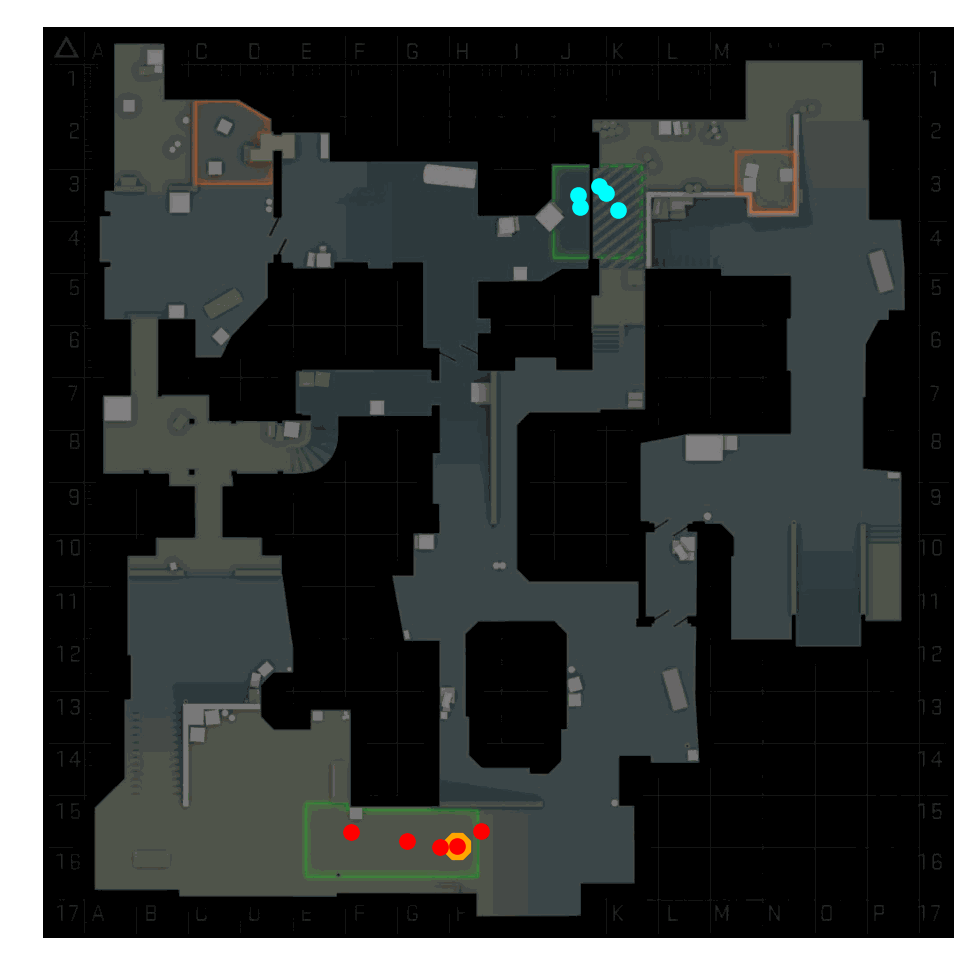

In [8]:
Image(filename=f"{dataset}/shortest_round_original.gif",
      width=700,
      height=700)

## Team as T or CT

In [9]:
data["gameRounds"][:2]== list([data["gameRounds"][0], data["gameRounds"][1]])

True

In [7]:
player_stats_json = player_stats(data["gameRounds"])
df= pd.DataFrame(player_stats_json).T

team_names = df.teamName.unique().tolist()
map_name = data["mapName"]

first_team_ct_idx = [i for i in range(len(data["gameRounds"])) if (data["gameRounds"][i]["ctTeam"] == f"{team_names[0]}")]
second_team_ct_idx = [i for i in range(len(data["gameRounds"])) if (data["gameRounds"][i]["ctTeam"] == f"{team_names[1]}")]

In [8]:
first_team_ct_rounds = list([data["gameRounds"][idx] for idx in first_team_ct_idx])

In [9]:
g_color_dict = {
                    "Incendiary Grenade": "purple",
                    "Molotov": "red",
                    "Smoke Grenade": "gray",
                    "HE Grenade": "green",
                    "Flashbang": "gold",
                }

In [10]:
from typing import Literal, get_args

In [11]:
from matplotlib import patches
from awpy.visualization.plot import position_transform

In [12]:
def plot_map2(
    map_name: str = "de_dust2", map_type: str = "original", *, dark: bool = False
):
    """Plots a blank map.

    Args:
        map_name (str, optional): Map to search. Defaults to "de_dust2"
        map_type (str, optional): "original" or "simpleradar". Defaults to "original"
        dark (bool, optional): Only for use with map_type="simpleradar".
            Indicates if you want to use the SimpleRadar dark map type
            Defaults to False

    Returns:
        matplotlib fig and ax
    """
    base_path = os.path.join(os.path.dirname(awpydata.__file__), f"""../data/map/{map_name}""")

    if map_type == "original":
        map_bg = imread(f"{base_path}.png")
        if map_name in MAP_DATA and "z_cutoff" in MAP_DATA[map_name]:
            map_bg_lower = imread(f"{base_path}_lower.png")
            map_bg = np.concatenate([map_bg, map_bg_lower])
    else:
        try:
            col = "dark" if dark else "light"
            map_bg = imread(f"{base_path}_{col}.png")
            if map_name in MAP_DATA and "z_cutoff" in MAP_DATA[map_name]:
                map_bg_lower = imread(f"{base_path}_lower_{col}.png")
                map_bg = np.concatenate([map_bg, map_bg_lower])
        except FileNotFoundError:
            map_bg = imread(f"{base_path}.png")
            if map_name in MAP_DATA and "z_cutoff" in MAP_DATA[map_name]:
                map_bg_lower = imread(f"{base_path}_lower.png")
                map_bg = np.concatenate([map_bg, map_bg_lower])

    fig = px.imshow(map_bg,
                    width=1000,height=1000)

    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)

    # fig.show()
    return fig, map_bg

    # figure, axes = plt.subplots()
    # axes.imshow(map_bg, zorder=0)
    # return figure, axes

In [ ]:
go.Box()

In [16]:
def plot_nades2(
    rounds: list,
    nades ,
    side: str = "CT",
    map_name: str = "de_ancient",
    map_type: str = "original",
    *,
    dark: bool = False,
):
    """Plots grenade trajectories.

    Args:
        rounds (list): List of round objects from a parsed demo
        nades (list, optional): List of grenade types to plot
            Defaults to []
        side (str, optional): Specify side to plot grenades. Either "CT" or "T".
            Defaults to "CT"
        map_name (str, optional): Map to search. Defaults to "de_ancient"
        map_type (str, optional): "original" or "simpleradar". Defaults to "original"
        dark (bool, optional): Only for use with map_type="simpleradar".
            Indicates if you want to use the SimpleRadar dark map type.
            Defaults to False

    Returns:
        matplotlib fig and ax
    """
    if nades is None:
        nades = []
    g_color_dict = {
                    "Incendiary Grenade": "purple",
                    "Molotov": "red",
                    "Smoke Grenade": "gray",
                    "HE Grenade": "green",
                    "Flashbang": "gold",
                }
    fig,_ = plot_map2(map_name=map_name, map_type=map_type, dark=dark)
    for game_round in rounds:
        if game_round["grenades"] is None:
            continue
        for grenade_action in game_round["grenades"]:
            if (
                grenade_action["throwerSide"] == side
                and grenade_action["grenadeType"] in nades
            ):
                start_x = position_transform(map_name, grenade_action["throwerX"], "x")
                start_y = position_transform(map_name, grenade_action["throwerY"], "y")
                end_x = position_transform(map_name, grenade_action["grenadeX"], "x")
                end_y = position_transform(map_name, grenade_action["grenadeY"], "y")
                g_color = g_color_dict[grenade_action["grenadeType"]]
                fig.add_traces(go.Scatter(
                    x=[start_x,end_x], 
                    y=[start_y, end_y],
                    line=dict(
                        color=g_color,
                        width=1),
                    name = grenade_action["grenadeType"],
                    # legendgroup= grenade_action["grenadeType"],
                    marker= dict(
                        size=5,
                        symbol= "arrow-bar-up", 
                        angleref="previous"),
                    showlegend=False
                    )
                    )
    ## Add custom legend
    for k,v in g_color_dict.items():
        fig.add_trace(
            go.Scatter(
                x = [None],
                y = [None],
                line=dict(
                            color=v,
                            width=1),
                name = k,
                marker= dict(
                        size=5,
                        symbol= "arrow-bar-up", 
                        angleref="previous"),

                showlegend=True
            )
        )
                # axes.plot([start_x, end_x], [start_y, end_y], color=g_color)
                # axes.scatter(end_x, end_y, color=g_color)
    # axes.get_xaxis().set_visible(b=False)
    # axes.get_yaxis().set_visible(b=False)

    # legend_handles = []
    
    # for nade_type in nades:
    #     color = g_color_dict[nade_type]
    #     legend_handles.append(patches.Patch(color=color, label=nade_type))
    # axes.legend(handles=legend_handles, title="Grenade Types",
    #             bbox_to_anchor = (1.1,1.1))'

    fig.show()
    return fig
    # return figure, axes

In [17]:
plot_nades2(rounds=first_team_ct_rounds,
           nades=["Flashbang", "Smoke Grenade", "Molotov", "HE Grenade", "Incendiary Grenade"],
           side="T",
           map_name=map_name,
           map_type="original")

/var/folders/10/q3npnksn53s54hvsz9643j140000gn/T/ipykernel_2833/92110622.py:9: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



AttributeError: 'tuple' object has no attribute 'add_traces'

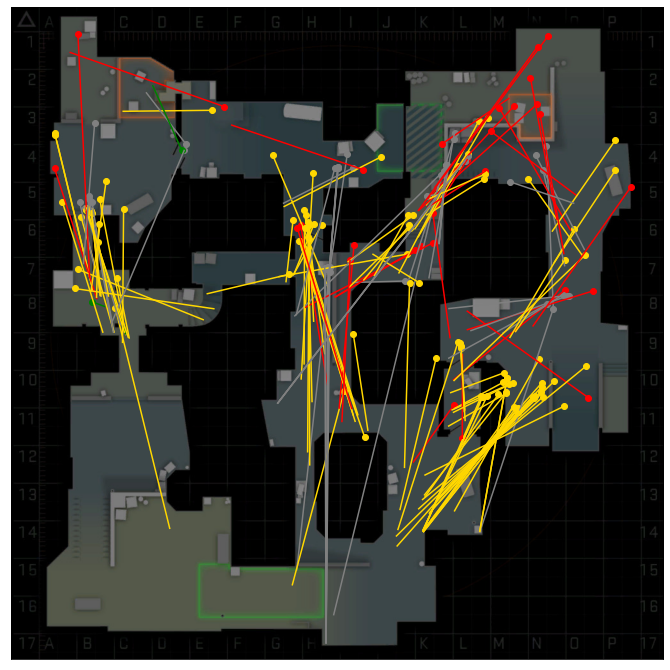

In [15]:
figure, axes = plot_nades(rounds=first_team_ct_rounds,
                          nades= ["Flashbang", "Molotov", "Smoke Grenade", "HE Grenade", "Incendiary Grenade"],
                          side="T",
                          map_name=map_name,
                          map_type="original")

figure.set_figheight(12)
figure.set_figwidth(12)
figure.show()
plot_nades2(rounds=first_team_ct_rounds,
           nades=["Flashbang", "Smoke Grenade", "Molotov", "HE Grenade"],
           side="T",
           map_name=map_name,
           map_type="original")

In [113]:
728.2352941176373-728.2352941176375

-2.2737367544323206e-13

In [118]:
position_transform("de_dust2", 728.2352941176373, "x")
position_transform("de_dust2", 728.2352941176375, "x")


-1.1368683772161603e-13

In [139]:
df_map_area =NAV_CSV[NAV_CSV["mapName"] == map_name]

df_map_area.head()

mapName  areaId       areaName  northWestX  northWestY  northWestZ  \
5577  de_dust2    8773      BombsiteA       800.0      2400.0  127.031250   
5578  de_dust2    1442      LongDoors       625.0       600.0    0.471580   
5579  de_dust2    3765      BombsiteB     -2050.0      1950.0    1.638456   
5580  de_dust2    7518         BDoors     -1200.0      2625.0   57.824059   
5581  de_dust2    6608  OutsideTunnel     -1325.0       275.0    7.367699   

      southEastX  southEastY  southEastZ  
5577       825.0      2425.0  127.031250  
5578       650.0       650.0    1.535376  
5579     -2025.0      2025.0    0.163017  
5580     -1125.0      2700.0   85.663452  
5581     -1300.0       300.0    8.031246

In [149]:
(df_map_area.northWestY ==df_map_area.southEastY).sum()

0

In [150]:
fig, map_bg = plot_map2(map_name=map_name,
                map_type="original")

In [165]:
len(NAV[map_name].keys())

1120

In [176]:
fig, map_bg = plot_map2(map_name=map_name,
                map_type="original")
fig.add_trace(
    go.Histogram2d(
        x = np.array([NAV[map_name][key]["northWestX"] for key in NAV[map_name].keys()]),
        autobinx=False,
        autobiny=False,
        nbinsx=1,
        nbinsy=1,
        y = np.array([NAV[map_name][key]["southEastY"] for key in NAV[map_name].keys()]),
        z = np.array([np.random.uniform(low=0,high=1, size=1120)]),
        colorscale="RdBu_r",
    )
)

fig.show()

In [151]:
area["northWestX"]

728.2352941040783

In [129]:
map_name = data["mapName"]

scale = MAP_DATA[map_name]["scale"]
# List to store plotly figure elements
figure_data = []

for i,a in enumerate(NAV[map_name]):

    area = NAV[map_name][a]
    # Transform positions using position_transform function
    area["southEastX"] = position_transform("de_dust2", area["southEastX"], "x")
    area["northWestX"] = position_transform("de_dust2", area["northWestX"], "x")
    area["southEastY"] = position_transform("de_dust2", area["southEastY"], "y")
    area["northWestY"] = position_transform("de_dust2", area["northWestY"], "y")

    # Calculate width and height
    width = area["southEastX"] - area["northWestX"]
    height = area["northWestY"] - area["southEastY"]

    # Define fill color (transparent for rectangle outline)
    fill_color = 'yellow'  # Transparent

    # Create a plotly rectangle using go.layout.Shape
    rect_data = go.layout.Shape(
        type="rect",
        x0=area["northWestX"],  # Starting x position (bottom left)
        y0=area["southEastY"],  # Starting y position (bottom left)
        x1=area["northWestX"] + width,  # Ending x position (top right)
        y1=area["southEastY"] - height,  # Ending y position (top right)
        fillcolor=fill_color,
        line=dict(color="yellow", width=1)  # Yellow outline
    )

    # Add rectangle data to figure_data list
    figure_data.append(rect_data)
        



In [42]:
map_name = data["mapName"]

scale = MAP_DATA[map_name]["scale"]
for i,a in enumerate(NAV[map_name]):
    area = NAV[map_name][a]
    area["southEastX"] = position_transform(map_name, area["southEastX"], "x")
    area["northWestX"] = position_transform(map_name, area["northWestX"], "x")
    area["southEastY"] = position_transform(map_name, area["southEastY"], "y")
    area["northWestY"] = position_transform(map_name, area["northWestY"], "y")
    width = (area["southEastX"] - area["northWestX"])
    heaight = (area["northWestY"] - area["southEastY"])
    southwest_x = area["northWestX"]
    southwest_y = area["southEastY"]
    fig.add_shape(type="rect",
                  x0=southwest_x, y0=southwest_y, 
                  x1=(southwest_x+height), 
                  y1=(southwest_y+width),
                  line=dict(color="green",
                            width=10),
                            fillcolor="red")
    if i==100:
        break
fig.show()

In [87]:
from matplotlib import patches

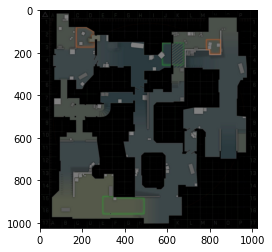

In [51]:
f, ax = plot_map(map_name = "de_dust2", map_type = 'original', dark = True)

for a in NAV["de_dust2"]:
    area = NAV["de_dust2"][a]
    area["southEastX"] = position_transform("de_dust2", area["southEastX"], "x")
    area["northWestX"] = position_transform("de_dust2", area["northWestX"], "x")
    area["southEastY"] = position_transform("de_dust2", area["southEastY"], "y")
    area["northWestY"] = position_transform("de_dust2", area["northWestY"], "y")
    width = (area["southEastX"] - area["northWestX"])
    height = (area["northWestY"] - area["southEastY"])
    southwest_x = area["northWestX"]
    southwest_y = area["southEastY"]
    rect = patches.Rectangle(xy=(southwest_x,southwest_y),width= width,height= height, linewidth=20, edgecolor="yellow", facecolor="red")
    ax.add_patch(rect)

In [57]:
from awpy.analytics.nav import area_distance

graph_dist = area_distance(map_name="de_dust2", area_a=152, area_b=8970, dist_type="graph")
graph_dist

{'distanceType': 'graph',
 'distance': 30,
 'areas': [152,
  1213,
  8672,
  8677,
  8670,
  1835,
  9020,
  8821,
  1801,
  1384,
  8489,
  5222,
  5253,
  5237,
  6699,
  6700,
  6715,
  6698,
  6695,
  5225,
  5226,
  5221,
  1713,
  1714,
  1077,
  1263,
  7350,
  1421,
  1418,
  1074,
  8970]}

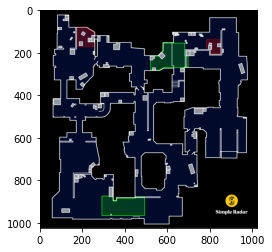

In [59]:
geodesic_dist = area_distance(map_name="de_dust2", area_a=8970, area_b=152, dist_type="geodesic")
f, ax = plot_map(map_name = "de_dust2", map_type = 'simpleradar', dark = True)

for a in NAV["de_dust2"]:
    area = NAV["de_dust2"][a]
    color = "None"
    if a in geodesic_dist["areas"]:
        color = "red"
    width = (area["southEastX"] - area["northWestX"])
    height = (area["northWestY"] - area["southEastY"])
    southwest_x = area["northWestX"]
    southwest_y = area["southEastY"]
    rect = patches.Rectangle((southwest_x,southwest_y), width, height, linewidth=1, edgecolor="yellow", facecolor=color)
    ax.add_patch(rect)


In [69]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=[1.5, 4.5],
    y=[0.75, 0.75],
    text=["Unfilled Rectangle", "Filled Rectangle"],
    mode="text",
))

# Set axes properties
fig.update_xaxes(range=[0, 7], showgrid=False)
fig.update_yaxes(range=[0, 3.5])

# Add shapes
fig.add_shape(type="rect",
    x0=1, y0=1, x1=2, y1=3,
    line=dict(color="RoyalBlue"),
)

fig.add_shape(type="rect",
              xref="paper",
              yref="paper",
    x0=1, y0=1, x1=2, y1=3,
    line=dict(color="RoyalBlue"),
    fillcolor="red",
)

fig.update_shapes(dict(xref='x', yref='y'))
fig.show()